- title: When Regressions Attack
- tags: statistics, week10, bsdetection
- date: 2018-12-3

This lesson is all about what can go wrong in linear regression.  It is organized into two sections: formal mistakes, and substantive mistakes.


- Formal mistakes ("assumptions of regression")
    - heteroskadiscity
    - multicolinnearity
    - data isn't linear
- Substantive mistakes
    - omitted variable bias
    
(simpson's paradox??)
(anscombe's quartet??)


Often, this material is taught in terms of "assumptions of regression."  We say that linear regression assumes certain things about your data/the world that your data represent.  This is kind of indirect language, however. When stats people talk about "assumptions" what they really mean are "things that have to be true or the regression gets the wrong answer."  So we'll just directly talk about the wrong answer and how it can be detected or avoided.

Another way to think about this is as a core part (along with the discussion of p values and power from a couple weeks ago) of your developing a BS detector for statistical claims, offered by scientific studies, expert witnesses, or otherwise.  One way of spewing statistical BS is to report the results of a regression which fails these "assumptions" --- which doesn't actually give you real information.  So in order to keep from being taken in by the BS, you need to know how regressions can go wrong.

(link for bottom: nice clear explanations http://statisticsbyjim.com/regression/ols-linear-regression-assumptions/ ) 

## Linear Regression: read the first word again.

In a lot of ways, the fundamental technical flaw of bad linear regressions is to use it to attempt to represent nonlinear relationships. Remember that what a linear regression does is draws a line (in two dimensions, a plane, or a *hyperplane* (wooooo) or such in more dimensions) that best allows us to predict the dependent variable from the independent variables.  But what if the relationship isn't linear?  

There's a very famous set of data visualizations, called *Anscombe's quartet*, that illustrates this.  It's so important that they actually built it into seaborn, so we can just directly run an example plot from their own documentation and take a look: 

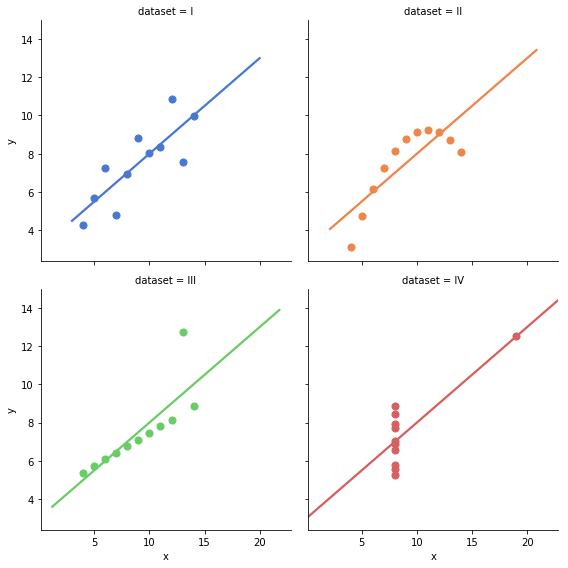

In [1]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

Anscombe's quartet is really deep (check out [the wikipedia page](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) for details).  What you're looking at is four distinct datasets that have identical means and variances in both x and y, identical correlation coefficients between x and y, and identical linear regression coefficients with identical r-squareds. (!!!!!)  

We're going to keep coming back to this, but for now I just want you to focus on the top row, and compare the top left with the top right. 

The top left is a great linear regression dataset.  The relationship looks very linear, in the sense that when x increases, y increases, and it looks like by about the same amount, give or take, each time. 

The top right is a terrible linear regression dataset.  You can visibly see that the line that OLS is trying to fit here doesn't even remotely match the shape of the data.  What this means is that you'll get regression coefficients out of this, but they won't mean very much at all, because there isn't actually relationship between x and y about which we can say "when x changes by some amount, y changes by some other amount"; or, at least, if there is such a range it doesn't exist over the entire range of x.  

Sometimes, data transformations can be used to make nonlinear data fit a linear form. The log transformation we looked at a few weeks ago, for example, is pretty good at suppressing some kinds of nonlinearity, though at the cost of making our regression coefficients a bit harder to figure out.  

Here, we might try a polynomial transformation, that is, instead of fitting the regression on x, maybe fit it on x squared, or x cubed.  That can allow the regression line to stop being, well, a line, and turn into a curve, which can more closely fit the data.  Indeed, this will turn out to be a pretty good match for this example.

In [4]:
quartet2 = df[df["dataset"] == "II"]

In [5]:
quartet2

,dataset,x,y
11,II,10.0,9.14
12,II,8.0,8.14
13,II,13.0,8.74
14,II,9.0,8.77
15,II,11.0,9.26
16,II,14.0,8.10
17,II,6.0,6.13
18,II,4.0,3.10
19,II,12.0,9.13
20,II,7.0,7.26


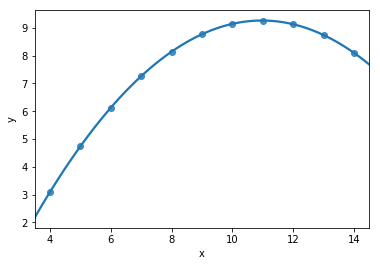

In [6]:
sns.regplot(x="x", y="y", data=quartet2, order=2)

In that code, the `order=2` parameter told seaborn to, behind the scenes, fit a polynomial regression with order 2 (that is, with a squared independent variable---order 3 would be a cubed independent variable) to the data.  So this would more accurately reflect our data, but the price (as with all such transformations) would, yet again, be that the coefficients would be harder to interpret. (When x-squared increases by A, y increases by B... huh?)

There's also another price to using higher-order regressions.  Very high-order polynomials are likely to "overfit."  What's overfitting?  Loosely, it's ... [write me]

(discussion of overfitting and advantage of parameters in terms of importing assumptions about general form of data rather than just reflecting the data you have, generalization.)